In [1]:
from framefinder import framedimensions
from framefinder import framelabels
base_model = "all-mpnet-base-v2"
dimensions = [
    "Care: ...acted with kindness, compassion, or empathy, or nurtured another person.",
    "Harm: ...acted with cruelty, or hurt or harmed another person/animal and caused suffering.",
    "Fairness: ...acted in a fair manner, promoting equality, justice, or rights.",
    "Cheating: ...was unfair or cheated, or caused an injustice or engaged in fraud.",
    "Loyalty: ...acted with fidelity, or as a team player, or was loyal or patriotic.",
    "Betrayal: ...acted disloyal, betrayed someone, was disloyal, or was a traitor.",
    "Authority: ...obeyed, or acted with respect for authority or tradition.",
    "Subversion: ...disobeyed or showed disrespect, or engaged in subversion or caused chaos.",
    "Sanctity: ...acted in a way that was wholesome or sacred, or displayed purity or sanctity.",
    "Degredation: ...was depraved, degrading, impure, or unnatural.",
]
pole_names = [
    ("Care", "Harm"),
    ("Fairness", "Cheating"),
    ("Loyalty", "Betrayal"),
    ("Authority", "Subversion"),
    ("Sanctity", "Degredation"),
]
candidate_labels = [
    "Economic: costs, benefits, or other financial implications",
    "Capacity and resources: availability of physical, human or financial resources, and capacity of current systems",
    "Morality: religious or ethical implications",
    "Fairness and equality: balance or distribution of rights, responsibilities, and resources",
    "Legality, constitutionality and jurisprudence: rights, freedoms, and authority of individuals, corporations, and government",
    "Policy prescription and evaluation: discussion of specific policies aimed at addressing problems",
    "Crime and punishment: effectiveness and implications of laws and their enforcement",
    "Security and defense: threats to welfare of the individual, community, or nation",
    "Health and safety: health care, sanitation, public safety",
    "Quality of life: threats and opportunities for the individual’s wealth, happiness, and well-being",
    "Cultural identity: traditions, customs, or values of a social group in relation to a policy issue",
    "Public opinion: attitudes and opinions of the general public, including polling and demographics",
    "Political: considerations related to politics and politicians, including lobbying, elections, and attempts to sway voters",
    "External regulation and reputation: international reputation or foreign policy of the U.S.",
    "Other: any coherent group of frames not covered by the above categories",
]

framing_labels = framelabels.FramingLabels("facebook/bart-large-mnli", candidate_labels)
framing_dimensions = framedimensions.FramingDimensions(
    base_model, dimensions, pole_names
)


In [2]:
import os
import numpy as np
import pandas as pd
def merge_csvs(directory):
    assert(os.path.exists(directory))
    files = [f for f in os.listdir(directory) if f.endswith(".csv")]
    assert(files)

    dfs = []
    for file in files:
        file_path = os.path.join(directory, file)
        dfs.append(pd.read_csv(file_path, header=[0, 1]))
    return pd.concat(dfs, axis=0)


def create_histogram(df, thresholds="auto"):
    histogram_df = pd.DataFrame()

    for col in df.columns:  # for each frame dimension
        hist, bin_edges = np.histogram(df[col], bins=thresholds)
        bin_labels = [
            f"{col}_bin_{round(thresholds[i], 2)}" for i in range(1, len(bin_edges))
        ]

        for label, count in zip(bin_labels, hist):
            histogram_df[label] = [count]

    return histogram_df

In [3]:
all_cop_reports = merge_csvs("COP/dumps/cluster/dimensions/by_year")
MEAN = means = all_cop_reports.mean()
STD = stds = all_cop_reports.std()
maxs = all_cop_reports.max()
mins = all_cop_reports.min()

for col in all_cop_reports.columns:
    print(f"Dimension: {col}")
    print(f"\tMean {means[col]}")
    print(f"\tStandard Deviation {stds[col]}")
    print(f"\tMax {maxs[col]}")
    print(f"\tMin {mins[col]}")

Dimension: ('Care', 'Harm')
	Mean 0.003513570672783691
	Standard Deviation 0.06679061562300741
	Max 0.3611722
	Min -0.33786857
Dimension: ('Fairness', 'Cheating')
	Mean 0.029302671378200362
	Standard Deviation 0.0691914296702329
	Max 0.420838
	Min -0.35027847
Dimension: ('Loyalty', 'Betrayal')
	Mean 0.018989331524556917
	Standard Deviation 0.06671613482932172
	Max 0.315159
	Min -0.3073308
Dimension: ('Authority', 'Subversion')
	Mean -0.003578741002816117
	Standard Deviation 0.07575636315735158
	Max 0.43739983
	Min -0.35433614
Dimension: ('Sanctity', 'Degredation')
	Mean -0.02542228994594739
	Standard Deviation 0.07618530231963114
	Max 0.310341
	Min -0.3678844


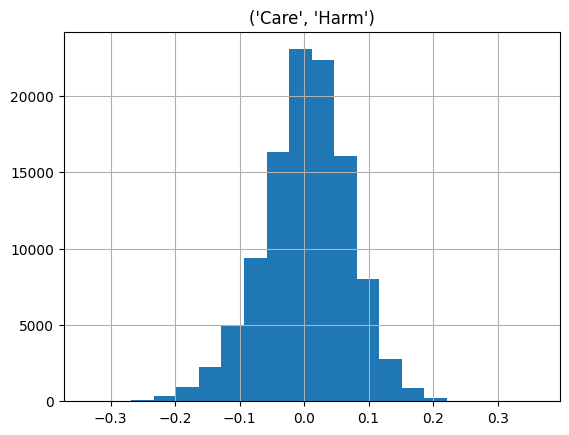

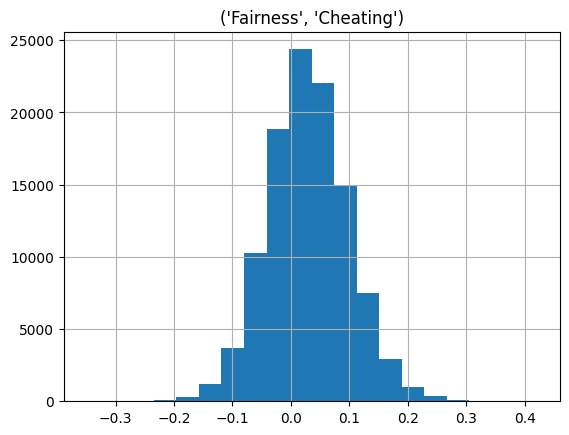

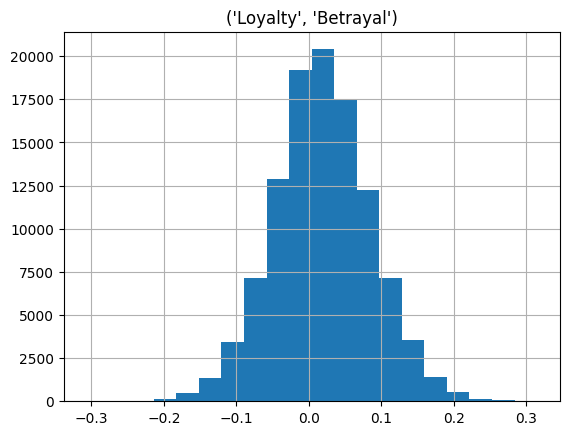

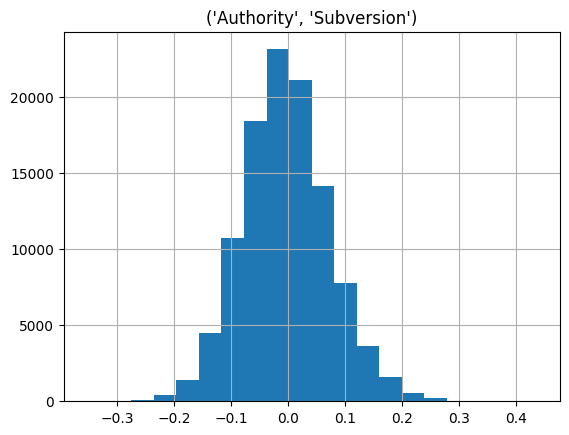

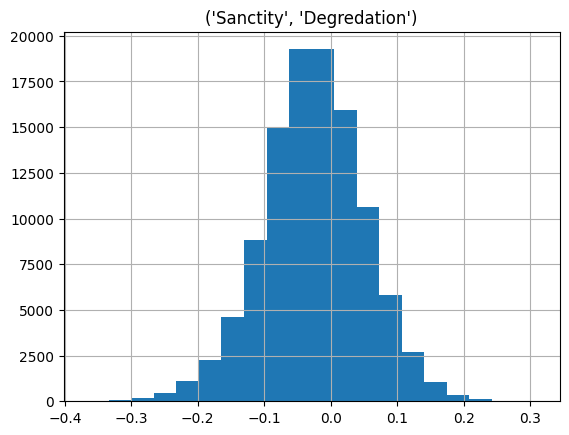

In [4]:
# todo mean + std in title
for col in all_cop_reports.columns:
    all_cop_reports.hist(column=col, bins=20)

In [5]:
# experimental
if False:
    from scipy.stats import norm
    from bisect import bisect_left

    def calculate_normal_percentile_of_sample(sample, mean, std):
        return norm.cdf(sample, mean, std) * 100

    def calculate_kth_normal_percentile(k, mean, std):
        return norm.ppf(k / 100, mean, std) 


    def prepare_and_sort_data(all_cop_reports):
        sorted_data = {col: np.sort(all_cop_reports[col].values) for col in all_cop_reports.columns}
        return pd.DataFrame(sorted_data)

    def calculate_percentile_empirically(sorted_df, sample_row):
        percentiles = []
        n_samples = len(sorted_df)
        
        for column in sorted_df.columns:
            sorted_column = sorted_df[column].values
            sample_value = sample_row[column]
            closest_index = bisect_left(sorted_column, sample_value)
            
            if closest_index >= n_samples:
                closest_index = n_samples - 1
            elif closest_index > 0 and abs(sorted_column[closest_index - 1] - sample_value) < abs(sorted_column[closest_index] - sample_value):
                closest_index -= 1
            
            percentiles.append(100 * (closest_index / n_samples))
            
        return percentiles

    def calculate_all_empirical_percentiles(sorted_df):
        pass

    sample_row = all_cop_reports.iloc[0]
    print(f"Sample Row:\n{sample_row}\n")

    print("Empirical Percentiles")
    percentiles = calculate_percentile_empirically(prepare_and_sort_data(all_cop_reports), sample_row)
    for i, (col, percentile) in enumerate(zip(all_cop_reports.columns, percentiles)):
        print(f"\t{col}: {round(percentile, 1)}")

    print("\nNormal Distribution Percentiles")
    percentiles = calculate_percentile_normal(sample_row, means, stds)
    for i, (col, percentile) in enumerate(zip(all_cop_reports.columns, percentiles)):
        print(f"\t{col}: {round(percentile, 1)}")

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

def visualize_boxplot(data_df, quantiles_25_df=None, quantiles_75_df=None):
    labels_right, labels_left = zip(*pole_names)

    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.boxplot(data_df, vert=False)
    if quantiles_25_df is not None:
        plt.boxplot(quantiles_25_df, vert=False)
    if quantiles_75_df is not None:
        plt.boxplot(quantiles_75_df, vert=False)
    plt.axvline(0)
    plt.gca().invert_yaxis()
    axi = ax.twinx()
    axi.set_ylim(ax.get_ylim())
    if quantiles_25_df is None and quantiles_75_df is None:
        axi.set_yticks(ax.get_yticks(), labels=labels_right)
        ax.set_yticks(ax.get_yticks(), labels=labels_left)
    plt.setp(ax.lines, markersize=0)  # Disables markers on left axis
    plt.setp(axi.lines, markersize=0)  # Disables markers on right axis
    plt.tight_layout()
    return fig


def compare_plots(dfs, titles, colors=None, legend=True, scale=0.25, percentiles_df=None):
    labels_right, labels_left = zip(*pole_names)
    means = [df.mean() for df in dfs]
    if colors is None:
        colors = list(mcolors.TABLEAU_COLORS) + list(mcolors.BASE_COLORS) + list(mcolors.CSS4_COLORS)

    fig, ax1 = plt.subplots() 
    ax2 = ax1.twinx() 
    plt.axvline(0)
    ax1.set_axisbelow(True)
    ax1.yaxis.grid(color="gray", linestyle="dashed")
    plt.xlim(-scale/2, scale/2)
    ax2.scatter(x=means[0], y=labels_right) # only needed for labels on the right
    ax2.plot()
    legend_entries = []
    for i in range(0, len(dfs)):
        legend_entries.append(mpatches.Patch(color=colors[i], label=titles[i]))
        ax1.scatter(x=means[i], y=labels_left, c=colors[i])
    if percentiles_df is not None:
        for row in percentiles_df.iterrows():
            ax1.plot(row[1], labels_left, color="gray", marker="|", linestyle="None")

    ax1.invert_yaxis()
    ax2.invert_yaxis()
    plt.gcf().set_size_inches(10, 7)
    plt.tight_layout()
    if legend:
        plt.legend(handles=legend_entries)
    return fig

# compares all csvs in a directory that contain given substring
def compare_by_substring(substring, directory, plot_directory="", percentiles=None):
    assert os.path.exists(directory)
    files = [
        f
        for f in os.listdir(directory)
        if f.__contains__(substring) and f.endswith(".csv")
    ]
    assert files
    if plot_directory:
        os.makedirs(plot_directory, exist_ok=True)
    dfs = []
    file_names = []
    means = []
    for file in files:
        file_path = os.path.join(directory, file)
        file_name = os.path.splitext(file)[0]
        df = pd.read_csv(file_path, header=[0, 1])
        dfs.append(df)
        file_names.append(file_name)
        means.append(df.mean())

    fig = compare_plots(dfs, file_names, percentiles_df=percentiles)
    plt.title(f"Comparison of {substring}")
    if plot_directory:
        fig.savefig(os.path.join(plot_directory, f"{substring}_comparison.png"), bbox_inches='tight')

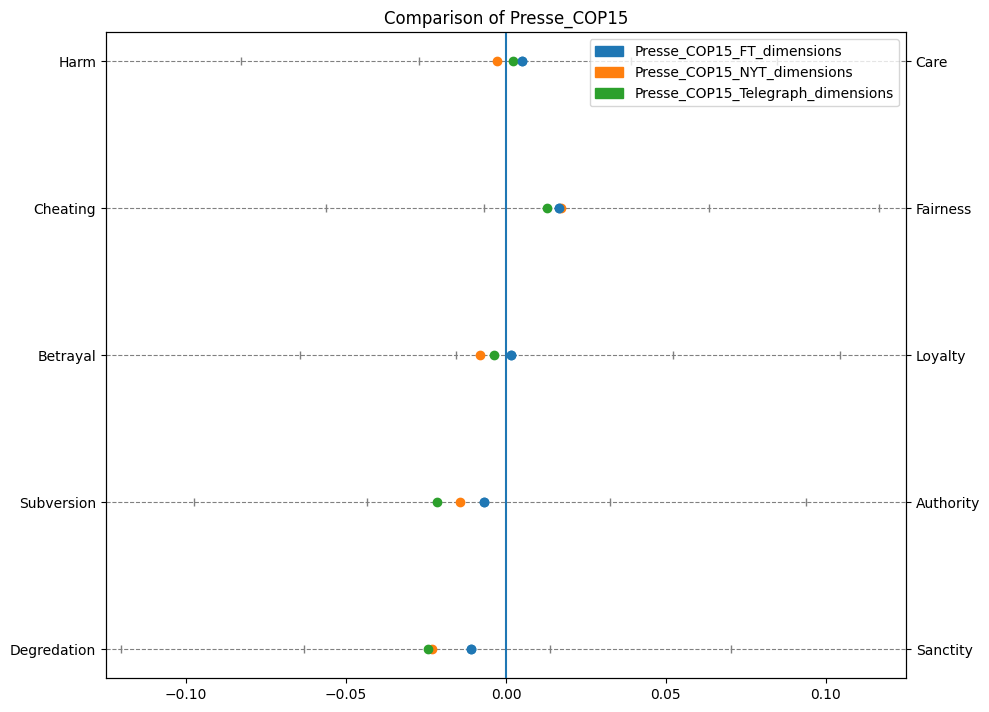

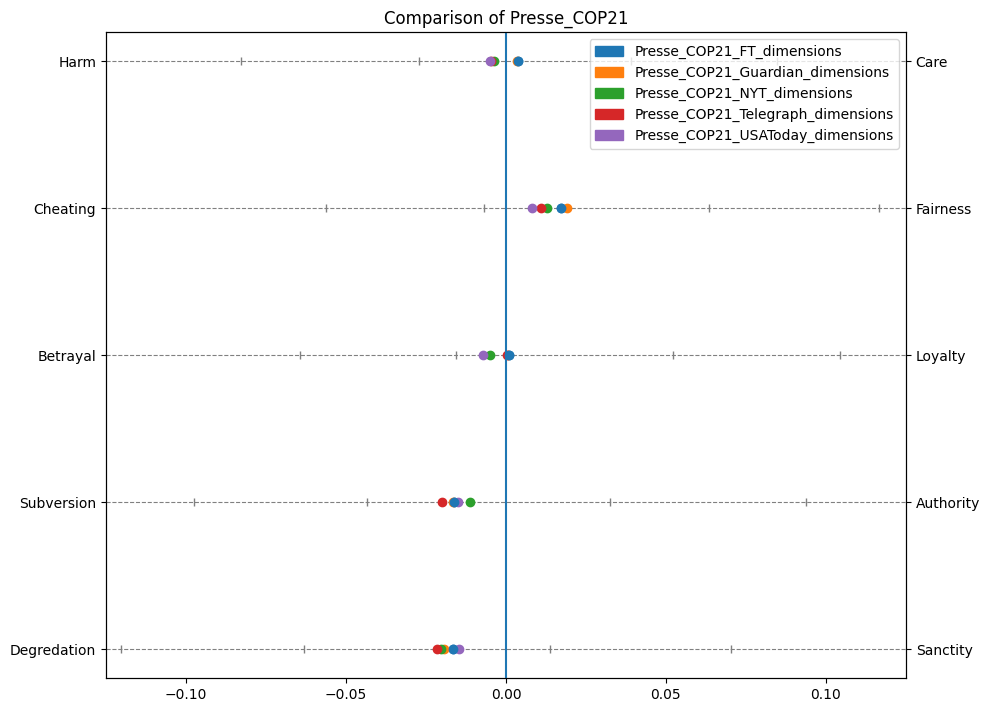

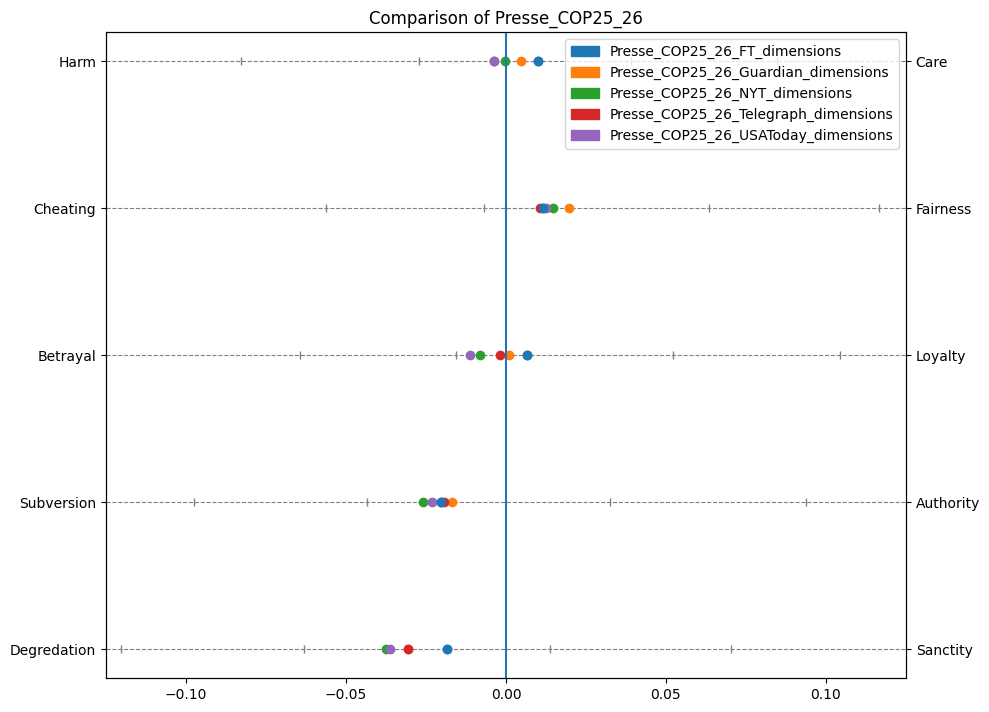

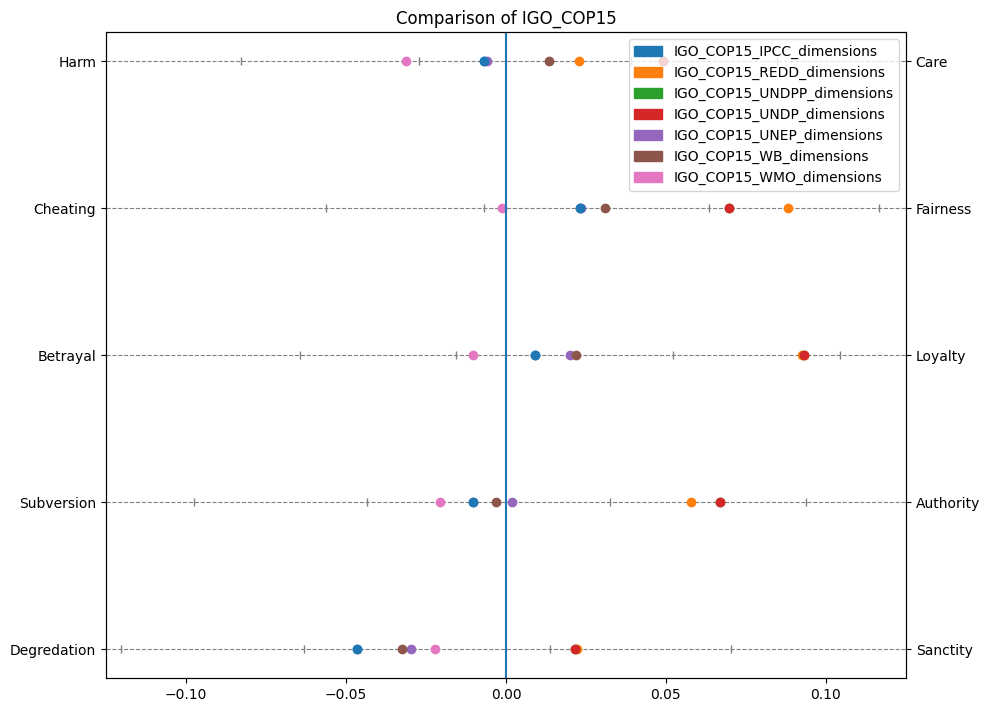

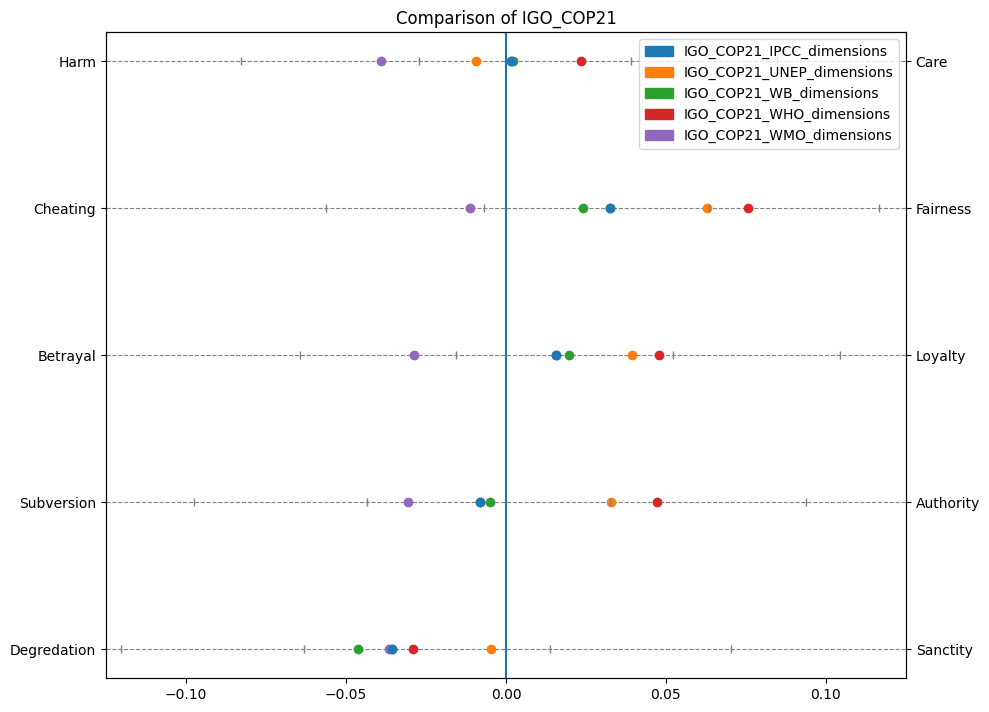

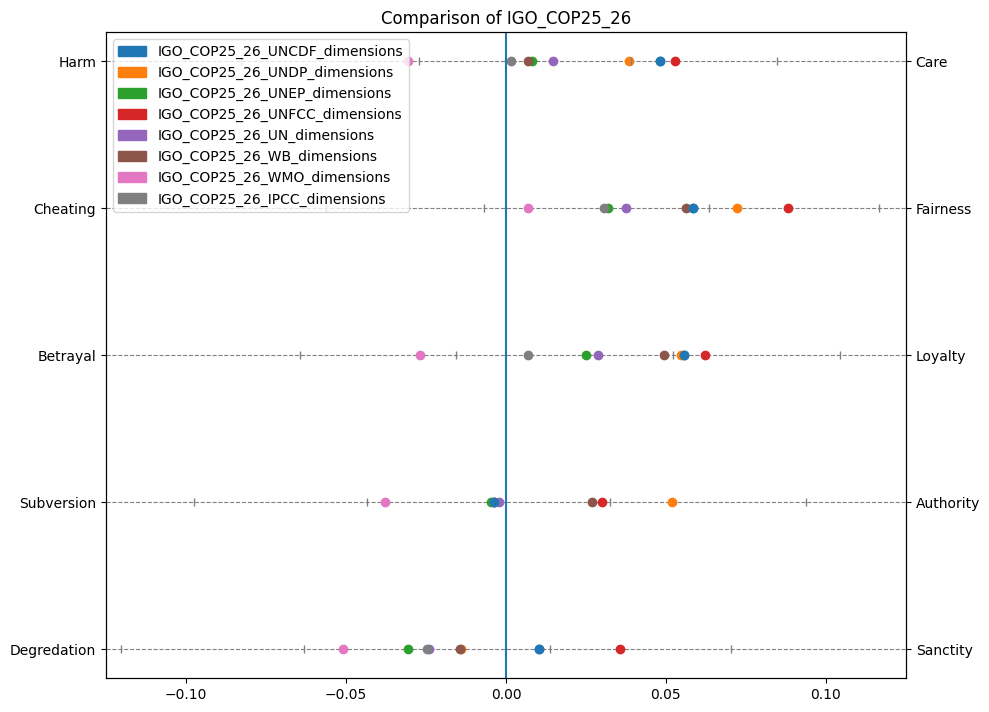

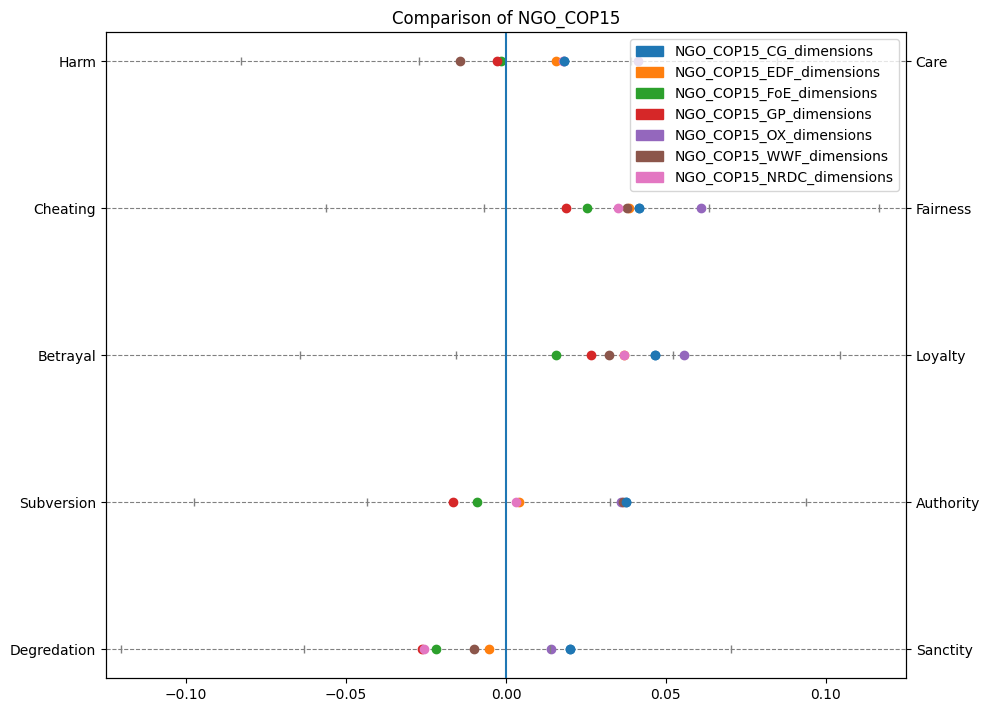

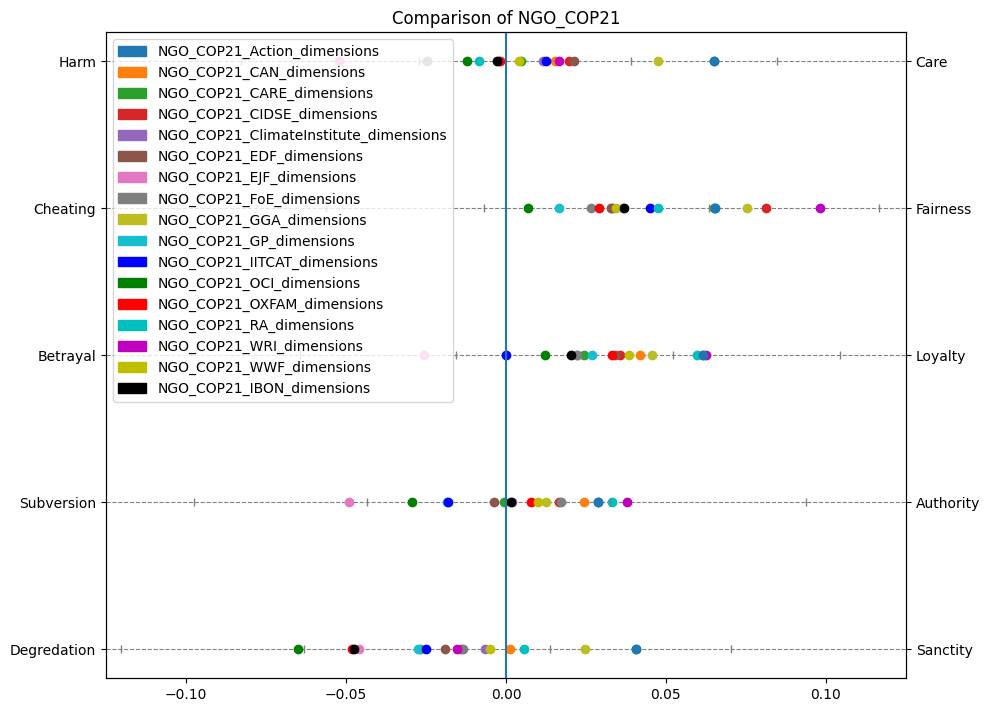

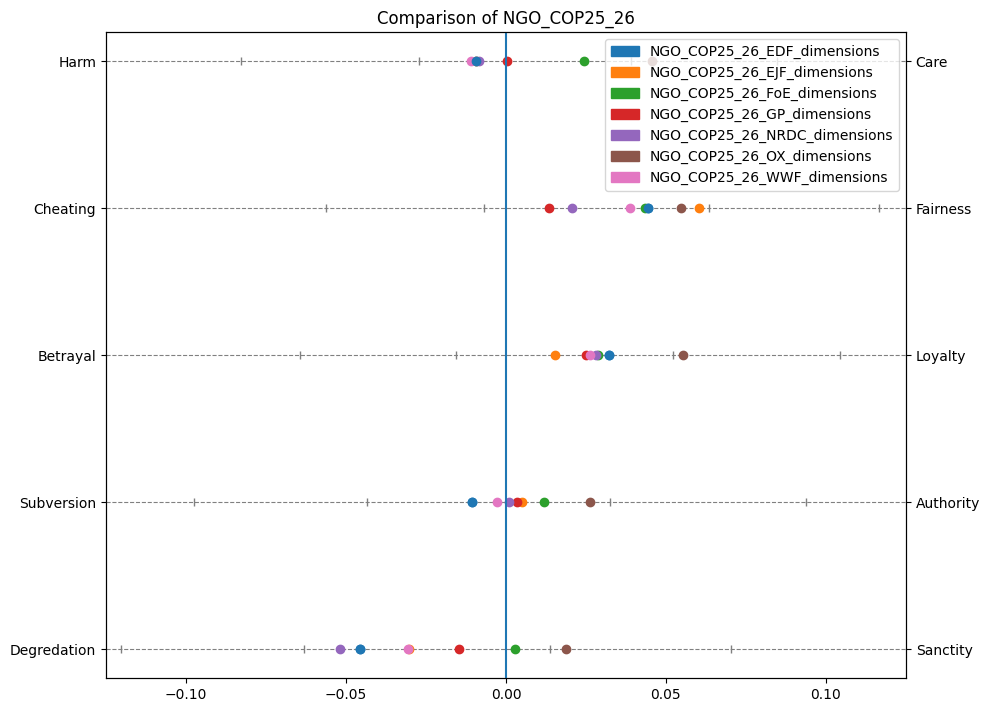

In [10]:
group_by = ["Presse_COP15", "Presse_COP21", "Presse_COP25_26", "IGO_COP15", "IGO_COP21", "IGO_COP25_26", "NGO_COP15", "NGO_COP21", "NGO_COP25_26"]
directory = "COP/dumps/cluster/dimensions/by_org"
plot_directory = "COP/plots/cluster/dimensions_with_percentiles"
percentiles = all_cop_reports.quantile([0.1, 0.3, 0.7, 0.9])
for group in group_by:
    compare_by_substring(group, directory, plot_directory, percentiles)

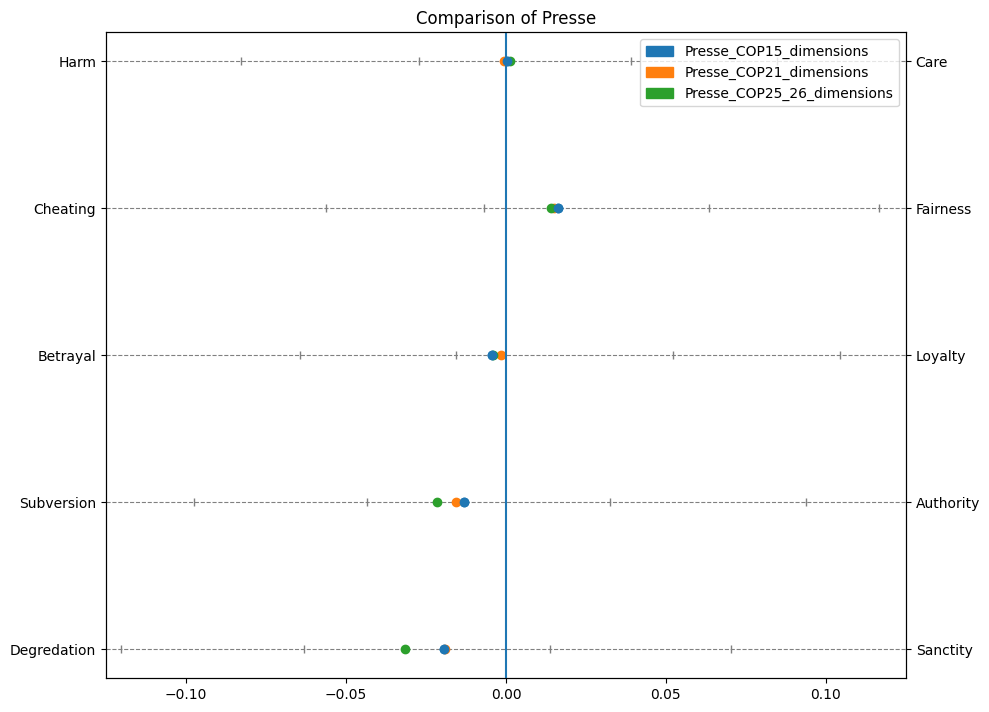

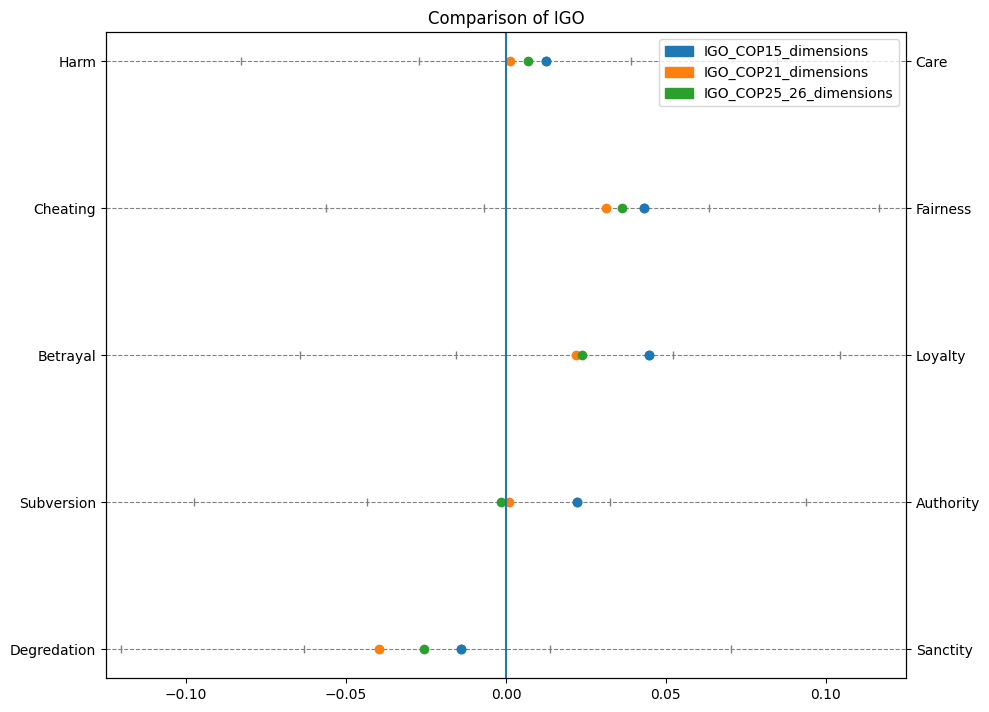

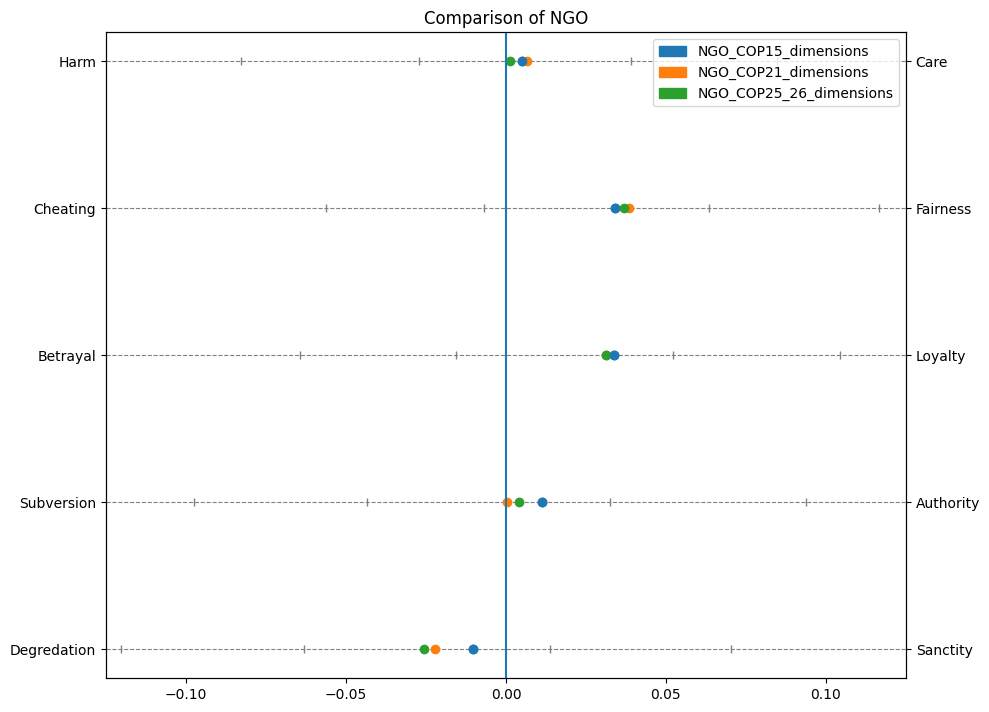

In [11]:
group_by = ["Presse", "IGO", "NGO"]
directory = "COP/dumps/cluster/dimensions"
plot_directory = "COP/plots/cluster/dimensions_with_percentiles"
percentiles = all_cop_reports.quantile([0.1, 0.3, 0.7, 0.9])
for group in group_by:
    compare_by_substring(group, directory, plot_directory, percentiles)

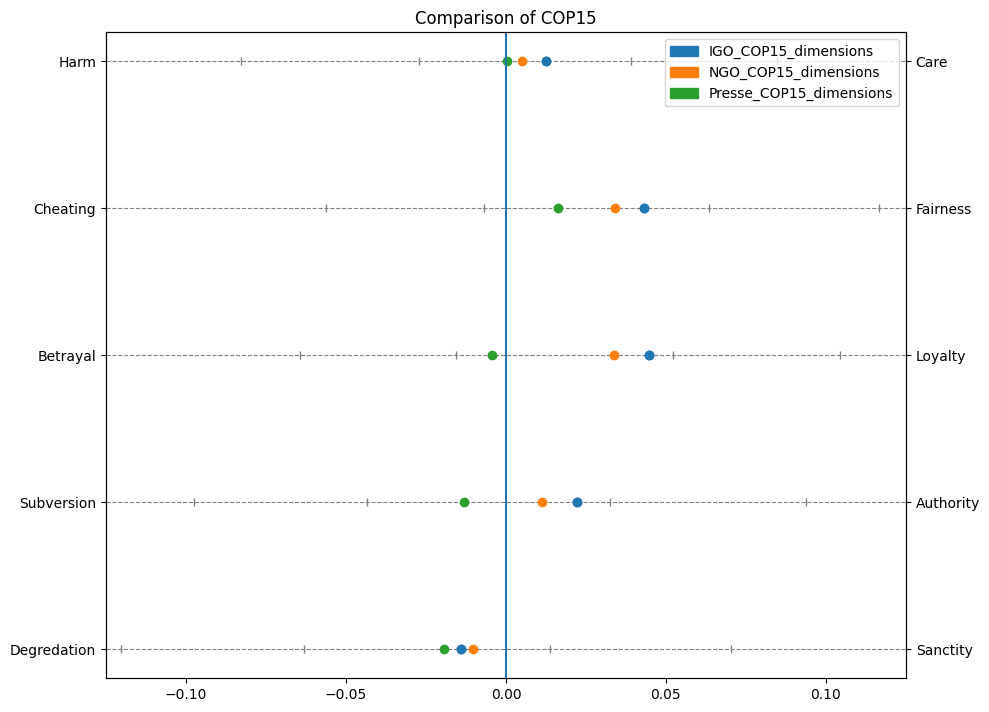

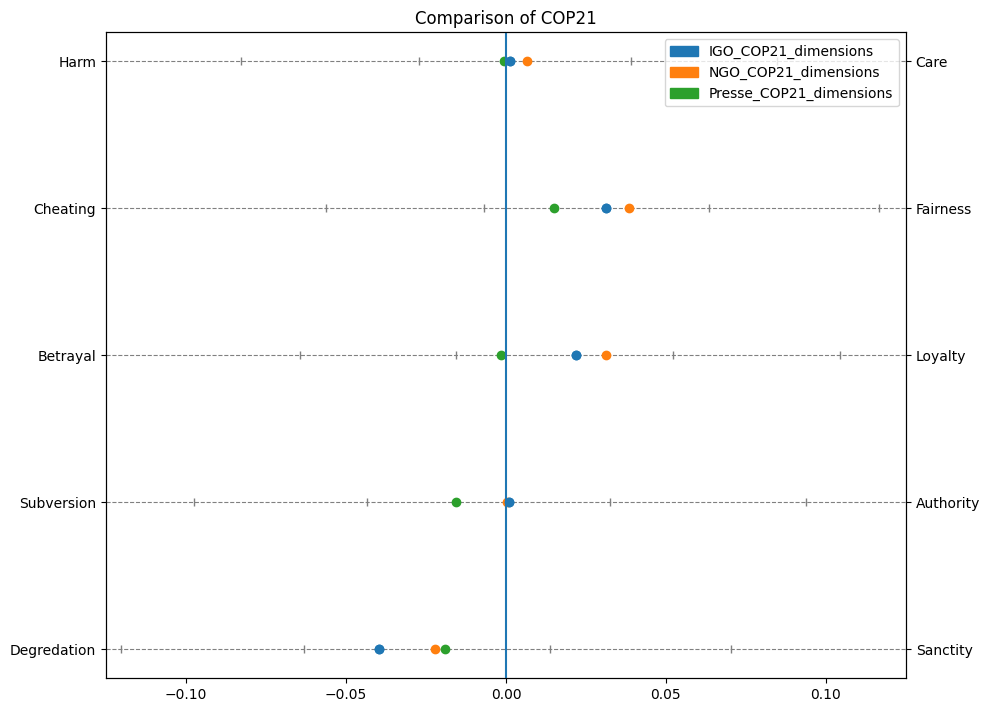

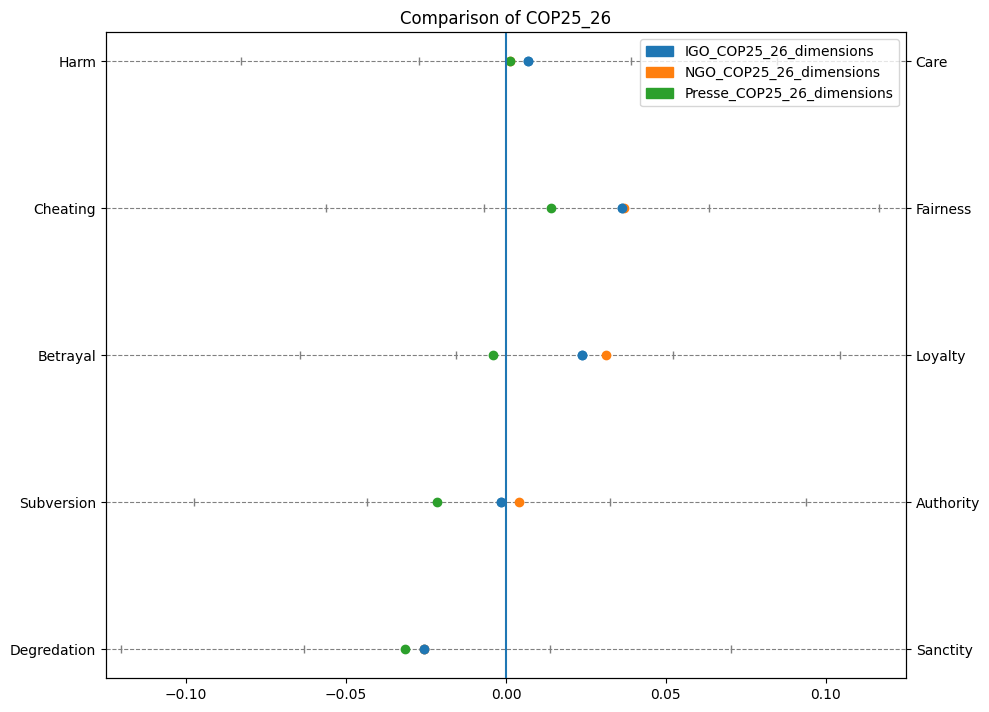

In [12]:
group_by = ["COP15", "COP21", "COP25_26"]
directory = "COP/dumps/cluster/dimensions"
plot_directory = "COP/plots/cluster/dimensions_with_percentiles"
percentiles = all_cop_reports.quantile([0.1, 0.3, 0.7, 0.9])
for group in group_by:
    compare_by_substring(group, directory, plot_directory, percentiles)